In [87]:
import numpy as np
from skimage import io
from utils import grainPreprocess, grainMark
from numpy.lib.stride_tricks import sliding_window_view

from matplotlib import pyplot as plt

from skimage import io, color, filters, morphology, util
from skimage.measure import EllipseModel
from skimage.color import rgb2gray
from skimage import filters, util
from skimage.morphology import disk, skeletonize, ball
from skimage.measure import approximate_polygon
from skimage import transform
import copy
from PIL import Image, ImageDraw, ImageFilter, ImageOps

from matplotlib import cm
import networkx as nx
from tqdm.notebook import tqdm

from bresenham import bresenham
import pandas as pd

from shapely.geometry import Polygon, LineString
import rasterio.features
import matplotlib.pyplot as plt

from networkx.drawing import draw_networkx
import itertools

from multiprocessing import Lock, Process, Queue, current_process
import multiprocessing

In [88]:
def draw_contours(image, cnts, color=(0, 139, 139), r=4, e_width=5, l_width=4):

    img = copy.copy(image)
    draw = ImageDraw.Draw(img)

    for j, cnt in enumerate(cnts):
        if len(cnt) > 1:
            point = cnt[0]
            x1, y1 = point[1], point[0]

            for i, point2 in enumerate(cnt):
                p2 = point2

                x2, y2 = p2[1], p2[0]

                draw.ellipse((y2 - r, x2 - r, y2 + r, x2 + r), fill=color, width=e_width)
                draw.line((y1, x1, y2, x2), fill=(255, 140, 0), width=l_width)
                x1, y1 = x2, y2

    return img


def draw_edges(image, cnts, color=255, r=4, e_width=5, l_width=4):
    
    img = copy.copy(Image.fromarray(image))
    draw = ImageDraw.Draw(img)

    for j, cnt in enumerate(cnts):
        if len(cnt) > 1:
            point = cnt[0]
            x1, y1 = point[1], point[0]
            for i, point2 in enumerate(cnt):
                p2 = point2
                x2, y2 = p2[1], p2[0]

                draw.line((y1, x1, y2, x2), fill=color, width=l_width)
                x1, y1 = x2, y2

    return img

def draw_edges_2(image, cnts, color=255, r=4, e_width=5, l_width=4):
    
    img = copy.copy(image)
    draw = ImageDraw.Draw(img)

    for j, cnt in enumerate(cnts):
        if len(cnt) > 1:
            point = cnt[0]
            x1, y1 = point[1], point[0]
            for i, point2 in enumerate(cnt):
                p2 = point2
                x2, y2 = p2[1], p2[0]

                draw.line((y1, x1, y2, x2), fill='darkorange', width=l_width)
                x1, y1 = x2, y2

    return img


def preprocess_image_1(image):
    if len(image.shape)==3:
        image = color.rgb2gray(image)

    image = filters.rank.median(image, morphology.disk(3))

    global_thresh = filters.threshold_otsu(image)
    image = image > global_thresh
    binary = image*255
    binary = binary.astype(np.uint8)

    grad = abs(filters.rank.gradient(binary, morphology.disk(1)))
    bin_grad = (1 - binary + grad) * 127
    bin_grad = np.clip(bin_grad, 0, 255).astype(np.uint8)

    return bin_grad

def align_figures(img_viz):
    cnts=grainMark.get_contours(img_viz,tol=tol)

    cnts = [cnt for cnt in cnts if len(cnt)>2]
    polies=[ Polygon(cnt) for cnt in cnts]

    img_viz_raster = 1 - rasterio.features.rasterize(polies, out_shape=img_viz.shape)
    img_viz_raster = img_viz_raster*127
    img_viz = img_viz_raster.astype(np.uint8)+127
    # grad = abs(filters.rank.gradient(img_viz, morphology.disk(1)))
    
    img_viz_raster = rasterio.features.rasterize(polies, out_shape=img_viz.shape).astype(np.uint8)*255
    # img_viz_raster = img_viz_raster*127
    grad = abs(filters.rank.gradient(img_viz_raster, morphology.disk(1)))
    
    img_viz = np.clip(img_viz-grad,0,255).astype(np.uint8)
    return img_viz,cnts, grad

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 255)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

# Plot all points

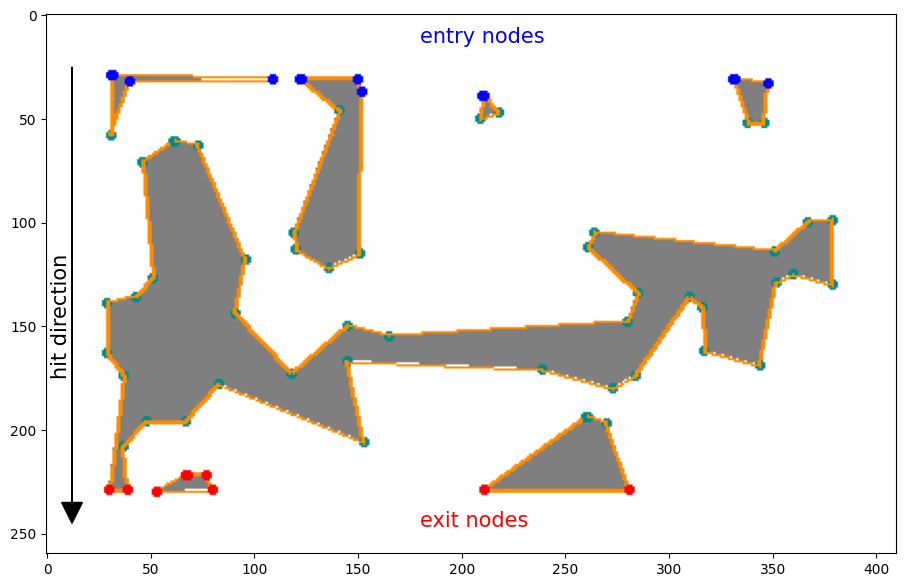

In [89]:
orig_img = io.imread('../datasets/original/o_bc_left/Ultra_Co6_2/Ultra_Co6_2-001.jpeg')[:200,:350]
# orig_img = io.imread('../datasets/original/o_bc_left/Ultra_Co11/Ultra_Co11-1.jpeg')[:600,:600]

#  некорректно
# orig_img = io.imread('../datasets/original/o_bc_left/Ultra_Co25/Ultra_Co25-001.jpeg')[:200,:200]


r=2
border = 30
# border = 5
border_eps = border + 10
tol = 4
    
tmp_img = preprocess_image_1(orig_img)
orig_img_padded = np.pad(tmp_img, border, pad_with)
img_viz,cnts, grad_viz = align_figures(orig_img_padded)

img_shape=np.array(img_viz.shape)

# coord2index
image_nodes_coord2nodes_index={}
nodes_index2global_nodes_coord={}
num_of_nodes=0

for points in reversed(cnts):
    for point in points:
        x,y = point[0],point[1]
        image_nodes_coord2nodes_index[(y,x)]=num_of_nodes
        nodes_index2global_nodes_coord[num_of_nodes]=(y,x)
        num_of_nodes+=1

# entry points
entry_nodes=[]

entry_dict={}

y_entry_max=0

for points in cnts:
    for point in points:
        if point[1]<border_eps:
            x,y = point[0],point[1]
            # condition to make end exit poits below start points 
            if y_entry_max<y:
                y_entry_max=y
            
            index=image_nodes_coord2nodes_index[(y,x)]
            entry_dict[index]=1
            entry_nodes.append(index)

# exit points
exit_nodes=[]
exit_dict={}

for points in cnts:
    for point in points:
        # if (point[0] < border_eps or img_shape[0] - point[0] < border_eps or img_shape[1] - point[1] < epborder_epss) and point[1]>y_entry_max:
        if (img_shape[0] - point[1] < border_eps):
            x,y = point[0],point[1]
            index=image_nodes_coord2nodes_index[(y,x)]
            exit_nodes.append(index)
            exit_dict[index]=1

img_drawings = copy.copy(Image.fromarray(img_viz)).convert('RGB')
img_drawings=draw_contours(img_drawings, cnts=cnts, r=2, l_width=2)
# img_drawings=draw_edges_2(img_drawings, cnts=cnts, r=2, l_width=1)
draw = ImageDraw.Draw(img_drawings)

# entry blue
for key in entry_nodes:
    x,y=nodes_index2global_nodes_coord[key]
    draw.ellipse((y - r, x - r, y + r, x + r), fill=(0,0,255), width=1)
    
# exit red
for key in exit_nodes:
    x,y=nodes_index2global_nodes_coord[key]
    draw.ellipse((y - r, x - r, y + r, x + r), fill=(255,0,0), width=1)
    
    
img_contours = draw_edges(np.zeros_like(img_viz), cnts=cnts, r=2, l_width=2)

fig,axes = plt.subplots(1,1,figsize=(14,7))



axes.imshow(img_drawings)
# axes[1].imshow(img_contours,cmap='gray')

axes.text(img_viz.shape[1]/2-25,border_eps/3,'entry nodes', color=(0, 0, 1),fontsize=15)
axes.text(img_viz.shape[1]/2-25,img_viz.shape[0] - border_eps/3,'exit nodes', color=(1, 0, 0),fontsize=15)
axes.arrow(12, border-5, 0, img_viz.shape[0] - border_eps, length_includes_head=True, head_width=10, head_length=10,color=(0,0,0))
axes.text(2, img_viz.shape[0]*2/3,'hit direction',rotation=90, color=(0, 0, 0),fontsize=15)

# plt.xlim(0,200)
# plt.ylim(0,50)

# plt.savefig('miniature_figures_aligned.png', bbox_inches='tight')
# plt.savefig('step_1.jpg', bbox_inches='tight')
# plt.savefig('step_2.jpg', bbox_inches='tight')
# plt.savefig('step_3.jpg', bbox_inches='tight')

plt.show()

In [ ]:
eps=100
line_eps = 2
border_eps = 0
border_number_min = 1
border_pixel=255
same_node_eps = 5
    
g = nx.DiGraph()
image_node_coord2node_index = np.zeros(img_shape,dtype=np.int32)
for key in range(num_of_nodes):
    x,y=nodes_index2global_nodes_coord[key]
    image_node_coord2node_index[x,y]=key
    g.add_node(key, pos=(y,x)) 

m=[]
a=[]

# nodes_index2global_nodes_coord = copy.copy(nodes_index2global_nodes_coord)
img_contours_np = np.array(img_contours)

for start_node_index in tqdm(range(num_of_nodes)):
    
    # choose cell
    start_node_x,start_node_y=nodes_index2global_nodes_coord[start_node_index]
    
    # for rectangular vertical slice only!
    ###############################################
    start_node_y +=1
    
    # left y slice border
    if start_node_y-eps<0:
        left_border_y=0
    else:
        left_border_y=start_node_y-eps-2

    # right y slice border
    if start_node_y+eps>image_node_coord2node_index.shape[1]:
        right_border_y=image_node_coord2node_index.shape[1]-1
    else:
        right_border_y=start_node_y+eps+2

    # upper_border
    if start_node_x+eps>image_node_coord2node_index.shape[1]-1:
        upper_border=image_node_coord2node_index.shape[1]-1
    else:
        upper_border=start_node_x+eps
        
    map_slice = image_node_coord2node_index[left_border_x:right_border_x,start_node_y:upper_border]
    print(map_slice.shape)
    ###############################################
    
    nodes_indices_indices = np.where(map_slice.flatten()!=0)
    nodes_indices = map_slice.flatten()[nodes_indices_indices]
    
    # next node search
    for node_index in nodes_indices:
    
        end_node_x, end_node_y = nodes_index2global_nodes_coord[node_index]

        if abs(end_node_x-start_node_x)>same_node_eps or abs(end_node_y-start_node_y)>same_node_eps:
        
            ab = LineString([(start_node_x, start_node_y), (end_node_x, end_node_y)])
            left = ab.parallel_offset(line_eps, 'left')
            left_p,_ = np.array(left.coords)
            perp_v = np.array((start_node_x-left_p[0],start_node_y-left_p[1]))
            perp_v = perp_v/np.linalg.norm(perp_v)
            
            mean_border_pixels=0
            if start_node_index==38 and node_index==37:
                print('-------')
                a.append(ab)
                a.append([start_node_index,node_index])
                
            for p in range(0 - line_eps, 1 + line_eps):
                line_coords=np.array(list(bresenham(np.round(start_node_x+p*perp_v[0]).astype(np.int32),
                                                    np.round(start_node_y+p*perp_v[1]).astype(np.int32),
                                                    np.round(end_node_x+p*perp_v[0]).astype(np.int32),
                                                    np.round(end_node_y+p*perp_v[1].astype(np.int32))
                                                   )))
                
                line_coords_pixels=img_contours_np[line_coords[:,0],line_coords[:,1]][2:-2]
                border_pixels_num = np.where(line_coords_pixels==border_pixel)[0].shape[0]
                if start_node_index==38 and node_index==37:
                    print(border_pixels_num)
                    m.append(line_coords)
                    
                    
                if border_pixels_num<=border_eps:
                    mean_border_pixels+=1
            if start_node_index==38 and node_index==37:
                print('result', mean_border_pixels)
            if mean_border_pixels>=border_number_min and start_node_index!=node_index:
                if start_node_index==38 and node_index==37:
                    print('added')
                g.add_edge(start_node_index,node_index, weight=np.linalg.norm((end_node_x-start_node_x, end_node_y-start_node_y)))
                
    
    # next node search
    # for node_index in nodes_indices:
    #     end_node_x,end_node_y=nodes_index2global_nodes_coord[node_index]
        
    #     mean_border_pixels=0
    #     for p in range(0 - line_eps, 1 + line_eps):
    #         line_coords=np.array(list(bresenham(start_node_x+p, start_node_y,end_node_x+p, end_node_y)))
            
    #         line_coords_pixels=img_contours_np[line_coords[:,1],line_coords[:,0]][2:-2]
    #         border_pixels_num = np.where(line_coords_pixels==border_pixel)[0].shape[0]
    #         if border_pixels_num<=border_eps:
    #             mean_border_pixels+=1
            
    #     if mean_border_pixels>=border_number_min and start_node_index!=node_index:
    #         g.add_edge(start_node_index,node_index, weight=np.linalg.norm((end_node_x-start_node_x, end_node_y-start_node_y)))



            

In [ ]:
map_slice.shape

In [ ]:
img_tmp = img_contours.convert('RGB')
img_tmp = 255 - np.array(img_tmp)
dark_pixels = img_tmp[:,:,0]==0
img_tmp[dark_pixels]=[255,0,0]

pos = nx.get_node_attributes(g, 'pos')
# fig,axes = plt.subplots(1,1,figsize=(25,25))
fig,axes = plt.subplots(1,1,figsize=(15,15))

nx.draw(g, pos, ax =axes,  with_labels=True, node_color='lightblue', node_size=500, font_size=15)
axes.imshow(img_tmp, cmap='gray')

# axes[0].invert_yaxis()
# axes[1].invert_yaxis()

plt.axis("on")
axes.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

axes.arrow(12, border-5, 0, 200, width=0.3, length_includes_head=True, head_width=10, head_length=10,color=(0,0,0))
axes.text(5,150,'hit direction',rotation=90, color=(0, 0, 0),fontsize=25)
axes.text(img_viz.shape[1]/2-25, border/3,'entry nodes', color=(0, 0, 1),fontsize=25)
axes.text(img_viz.shape[1]/2-25,img_viz.shape[1] - border/3,'exit nodes', color=(1, 0, 0),fontsize=25)

# plt.savefig('graph.jpg',bbox_inches='tight')
plt.show()

In [ ]:
# plt.figure(figsize=(15,15))
# plt.imshow(img_contours_np,cmap='gray')
# for line_coords in m:
#     plt.plot(line_coords[:,0][2:-2],line_coords[:,1][2:-2])
    
# plt.xlim(0,200)
# plt.ylim(150,250)

In [ ]:
eps=100
line_eps = 2
border_eps = 0
border_number_min = 1
border_pixel=255

start_node_index = 38
node_index = 37

start_node_x,start_node_y=nodes_index2global_nodes_coord[start_node_index]
end_node_x, end_node_y = nodes_index2global_nodes_coord[node_index]
print(start_node_x,start_node_y)
print(end_node_x, end_node_y)


ab = LineString([(start_node_x, start_node_y), (end_node_x, end_node_y)])
left = ab.parallel_offset(line_eps, 'left')
left_p,_ = np.array(left.coords)
perp_v = np.array((start_node_x-left_p[0],start_node_y-left_p[1]))
perp_v = perp_v/np.linalg.norm(perp_v)

mean_border_pixels=0

n=[]
for p in range(0 - line_eps, 1 + line_eps):
    line_coords=np.array(list(bresenham(np.round(start_node_x+p*perp_v[0]).astype(np.int32),
                                        np.round(start_node_y+p*perp_v[1]).astype(np.int32),
                                        np.round(end_node_x+p*perp_v[0]).astype(np.int32),
                                        np.round(end_node_y+p*perp_v[1].astype(np.int32))
                                       )))
    
    line_coords_pixels=img_contours_np[line_coords[:,1],line_coords[:,0]][2:-2]
    border_pixels_num = np.where(line_coords_pixels==border_pixel)[0].shape[0]
    n.append(line_coords)

    print(mean_border_pixels)
    if border_pixels_num<=border_eps:
        mean_border_pixels+=1

print('result', mean_border_pixels)
if mean_border_pixels>=border_number_min and start_node_index!=node_index:
    print('added')
    g.add_edge(start_node_index,node_index, weight=np.linalg.norm((end_node_x-start_node_x, end_node_y-start_node_y)))


In [ ]:
np.array(ab)

In [ ]:
# for i in range(len(n)):
#     print('--------------')
#     print(n[i][:10])
#     print('----')
#     print(m[i][:10])

In [ ]:
g.has_edge(38,37)

In [ ]:
import pickle

# save graph object to file
pickle.dump(g, open('g.pickle', 'wb'))

# Graph traversal

In [ ]:
%%time

workers = 8

def do_job(tasks_to_accomplish,result_queue,  tqdm_queue):
    while not tasks_to_accomplish.empty():
        entry_node, exit_node = tasks_to_accomplish.get()
        paths = list(nx.all_simple_paths(g, source=entry_node, target=exit_node))
        tqdm_queue.put(1)
        result_queue.put([{'paths':paths,
                          'entry_node':entry_node,
                          'exit_node':exit_node,}])

cart_list=[entry_nodes, exit_nodes]
cart_list=[element for element in itertools.product(*cart_list)]

number_of_tasks = len(cart_list)

tasks_to_accomplish = Queue()
result_queue = Queue()
tqdm_queue = Queue()
processes = []

for i in range(number_of_tasks):
    tasks_to_accomplish.put(cart_list[i])

for w in range(workers):
    p = Process(target=do_job, args=(tasks_to_accomplish, result_queue, tqdm_queue))
    processes.append(p)
    p.start()
    
with tqdm(total=number_of_tasks) as pbar:
    completed = 0
    while completed < number_of_tasks:
        tqdm_queue.get()
        pbar.update(1)
        completed += 1

results = []
while not result_queue.empty():
    results.extend(result_queue.get())

for p in processes:
    p.join()

In [ ]:
%%time

lengths_2=[]
for entry_node in tqdm(entry_nodes):
    for exit_node in exit_nodes:
        paths=list(nx.all_simple_paths(g, source=entry_node, target=exit_node))
        for path in paths:
            lengths_2.append(len(path))

In [ ]:
all_paths=[]
all_entry_nodes=[]
all_exit_nodes=[]
all_path_len_edges=[]
all_path_len_pixels=[]

for line in tqdm(results):
    paths,entry_node,exit_node=line['paths'],line['entry_node'],line['exit_node']
    for path in paths:
        all_paths.append(path)
        all_entry_nodes.append(entry_node)
        all_exit_nodes.append(exit_node)
        all_path_len_edges.append(len(path))
        l=nx.path_weight(g,path, 'weight')
        all_path_len_pixels.append(l)

df=pd.DataFrame({'path':all_paths,
                 'path_len_edges':all_path_len_edges,
                 'path_len_pixel':all_path_len_pixels,
                 'entry_node':all_entry_nodes,
                 'exit_node':all_exit_nodes,})

print(df.info())

df.head()

In [ ]:
df.head()

In [ ]:
print(list(g.nodes).__len__())
print(np.mean(lengths_adjusted))

In [ ]:
lengths_adjusted_2 = []
for l in results:
    lengths_adjusted_2.append(len(l))

lengths_adjusted_2 = np.array(lengths_adjusted_2)
print(np.mean(lengths_adjusted_2))  

In [ ]:
np.unique(df[df['path_len_edges']<22]['path_len_edges'])

In [ ]:
%%time

lengths_adjusted=df['path_len_edges']
std=lengths_adjusted.std(axis=0)
mean=np.mean(lengths_adjusted)

plt.figure(figsize=(7,5))
plt.hist(lengths_adjusted,bins=18)
plt.axvline(mean-2*std,color=(0.2,0.5,0.5))
plt.axvline(mean-std,color=(1,1,0))
plt.axvline(mean,color=(1,0,0))
plt.axvline(mean+std,color=(0,1,1))
plt.axvline(mean+2*std,color=(0,1,0.5))
plt.legend(['mean-2*std','mean-std','mean','mean+std','mean+2*std','length of path\nfrom entry to exit points '])
plt.xlabel('length of crack, pixels')
plt.xlim(4,22)
plt.savefig('entry_exit_paths_edges.jpg', bbox_inches='tight')
plt.show()

In [ ]:
np.array(g.degree)[:,1].mean()

In [ ]:
%%time

pixel = 50 / 1000

for i,exit_node in tqdm(enumerate(exit_nodes)):
    # lengths_adjusted=df[df['exit_node']==exit_nodes[i]]['path_len_pixel']
    lengths_adjusted=df[df['exit_node']==exit_nodes[i]]['path_len_edges']
    std=lengths_adjusted.std(axis=0)
    mean=np.mean(lengths_adjusted)
    plt.figure(figsize=(7,5))
    plt.title(f'Exit node {exit_node}')
    plt.hist(lengths_adjusted,bins=18)
    plt.axvline(mean-2*std,color=(0.2,0.5,0.5))
    plt.axvline(mean-std,color=(1,1,0))
    plt.axvline(mean,color=(1,0,0))
    plt.axvline(mean+std,color=(0,1,1))
    plt.axvline(mean+2*std,color=(0,1,0.5))
    plt.legend(['mean-2*std','mean-std','mean','mean+std','mean+2*std',f'paths len\nnumber of paths\n{len(lengths_adjusted)/10**6:.2f}*10^6'])
    plt.xlabel('length of crack, pixels')
    plt.savefig(f'entry_exit_paths_{i}_edges.jpg', bbox_inches='tight')
    plt.show()

In [ ]:
import math
import os
import pickle
import time
from datetime import timedelta
from itertools import islice
from multiprocessing import Manager, Process, Queue
from queue import Empty

import networkx as nx
import pandas as pd

# from clear_terminal import clear_terminal

TQueue = list[tuple[int, set[int]]]
TResults = list[set[int]]
TAdjDict = dict[int, list[int]]
TStateDict = dict[str, tuple[str, int | None, int | None]]

def batched(iterable, n, *, strict=False):
    # batched('ABCDEFG', 3) → ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    iterator = iter(iterable)
    while batch := tuple(islice(iterator, n)):
        if strict and len(batch) != n:
            raise ValueError('batched(): incomplete batch')
        yield batch


def breath_step(
        node: int,
        current_path: set[int],
        adj_dict: TAdjDict,
        stop_node: int,
        ) -> tuple[TQueue, TResults]:
    """One step to fill queue from node."""
    current_path = current_path | {node}
    results = []
    queue = []
    for neighbour in adj_dict[node]:
        if neighbour in current_path:
            continue
        if neighbour == stop_node:
            results.append(current_path | {neighbour})
        else:
            queue.append((neighbour, current_path.copy()))
    return queue, results


def process_queue(queue: TQueue, adj_dict: TAdjDict, stop_node: int) -> tuple[TQueue, TResults]:
    """Process queue and generate next queue and results."""
    next_queue = []
    results = []
    for node, current_path in queue:
        qu, res = breath_step(node, current_path, adj_dict, stop_node)
        next_queue.extend(qu)
        results.extend(res)
    return next_queue, results


def _any_is_working(state_dict: TStateDict) -> bool:
    return any(state in {"PROC ", "SPLIT"} for state, *_ in state_dict.values())


def process(
        queue: Queue,
        res_queue: Queue,
        adj_dict: TAdjDict,
        stop_node: int,
        max_size: int,
        proc_state: dict,
        timeout: int = 8
        ) -> TResults:
    # while done_flag.value == 0:
    pid = os.getpid()
    proc_state[pid] = ("STARTING", None, 0, None)
    processed = 0
    results = []
    next_queue = []
    extra_queue = []

    while True:
        proc_state[pid] = ("GET  ", 0, len(extra_queue), processed, len(results))
        try:
            next_queue = queue.get(block=True, timeout=timeout)
        except Empty:
            if extra_queue:
                next_queue = extra_queue[:max_size]
            elif not _any_is_working(proc_state):
                break
        proc_state[pid] = ("PROC ", len(next_queue), len(extra_queue), processed, len(results))

        while 0 < len(next_queue) <= max_size:
            next_queue, res = process_queue(next_queue, adj_dict, stop_node)
        results.extend(res)

        proc_state[pid] = ("SPLIT", len(next_queue), len(extra_queue), processed, len(results))

        processed += 1
        if next_queue:
            for q in batched(next_queue, math.ceil(max_size / 3)):
                if queue.full():
                    extra_queue.extend(q)
                    proc_state[pid] = ("PANIC", None, len(extra_queue), processed, None)
                else:
                    queue.put(q, timeout=1)

    proc_state[pid] = ("QUIT ", None, None, processed, len(results))
    res_queue.put(results)


def update_state(state_df: pd.DataFrame, state_dict: TStateDict) -> pd.DataFrame:
    for pid, data in dict(state_dict).items():
        state_df.loc[pid] = data
    if -1 in state_df.index and state_df.shape[0] > 1:
        state_df.drop(index=-1, axis="index", inplace=True)
    return state_df


def create_processes(
        n_processes: int,
        queue: Queue,
        res_queue: Queue,
        adj_nodes: TAdjDict,
        end_node: int,
        max_size: int,
        process_dict: TStateDict,
) -> list[Process]:
    """Create list of processes."""
    args = (queue, res_queue, adj_nodes, end_node, max_size, process_dict)
    return [
        Process(target=process, args=args)
        for _ in range(n_processes)
    ]


def init_queue(n_processes: int, start_node: int, end_node: int, adj_nodes: TAdjDict) -> tuple[Queue, Queue]:
    """Init queue with starting nodes."""

    queue = Queue()
    results_queue = Queue()

    next_queue = [(start_node, set())]
    results = []
    while 0 < len(next_queue) <= n_processes:
        next_queue, res = process_queue(next_queue, adj_nodes, end_node)
        results.extend(res)

    for cond in next_queue:
        queue.put([cond])
    results_queue.put(results)
    return queue, results_queue


def print_state_table(state_df: pd.DataFrame) -> None:
    """Redraw table with states."""
    print("\033[0;0H")  # noqa: T201
    print(state_df)  # noqa: T201


def run_processes(processes: list[Process], queue: Queue, state_dict: TStateDict) -> None:
    """Run processes and pint state table."""
    for proc in processes:
        proc.start()

    print("Waiting for updates...")
    state_df = pd.DataFrame(columns=["state", "queue", "extra queue", "processed", "results"])
    state_df.loc[-1] = ["WAIT", "WAIT", "WAIT", "WAIT", "WAIT"]
    time.sleep(1)
    while True:
        time.sleep(0.1)
        update_state(state_df, state_dict)
        # print_state_table(state_df)
        if (state_df.state.isin(["PANIC", "QUIT "])).all():
            break

    print("Waiting on processes...")
    for proc in processes:
        proc.join()

    update_state(state_df, state_dict)
    # print_state_table(state_df)


def get_results(results_queue: Queue) -> TResults:
    """Get results from queue."""
    results = []
    while not results_queue.empty():
        res = results_queue.get()
        results.extend(res)
    return results


if __name__ == "__main__":
    START_NODE = 32
    END_NODE = 162
    N_PROCESSES = 6
    MAX_SIZE = 6000

    with open('g.pickle', 'rb') as fp:
        G = pickle.load(fp)

    adj_nodes = {node: list(neigh.keys()) for node, neigh in G.adjacency()}

    manager = Manager()
    process_state = manager.dict()

    # clear_terminal()

    print("Preparing...")
    start = time.time()
    queue, results_queue = init_queue(N_PROCESSES,  START_NODE, END_NODE, adj_nodes)
    processes = create_processes(N_PROCESSES, queue, results_queue, adj_nodes, END_NODE, MAX_SIZE, process_state)

    print("Running...")
    run_processes(processes, queue, state_dict=process_state)

    print("Retrieving results")
    results = get_results(results_queue)
    end = time.time()
    delta = timedelta(seconds=end-start)

    print(f"Graph contains {len(G)} nodes and {G.number_of_edges()} edges")
    print(f"Found {len(results)} paths in {str(object=delta)}")

    # start = time.time()
    # paths = list(nx.all_simple_paths(G, START_NODE, END_NODE))
    # end = time.time()
    # delta = timedelta(seconds=end-start)

    # print(f"NX found {len(paths)} paths in {str(object=delta)}")


# Dynamic grid search (not done)

img_viztmp_img1) image_nodes_coord2nodes_index
2) nodes_index2global_nodes_coord
3) image_node_coord2node_index

1) grid_cell_coord2grid_cell_index
2) grid_cell_index2grid_cell_coord
3) image_coord2grid_cell_index

In [ ]:
# process nodes of graph
# add all nodes to graph
g = nx.DiGraph()
image_node_coord2node_index = np.zeros(img_shape)
for key in range(num_of_nodes):
    x,y=nodes_index2global_nodes_coord[key]
    image_node_coord2node_index[x,y]=key
    g.add_node(key, pos=(x,y))
    
# pos = nx.get_node_attributes(g, 'pos')
# plt.figure(figsize = (5,5))
# nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [ ]:
# create grid
cell_size=10
grid_size=np.int32(img_shape/cell_size)

number_of_cells=0
grid_cell_coord2grid_cell_index={}
grid_cell_index2grid_cell_coord={}
image_coord2grid_cell_index = np.zeros(img_shape)
for xi in range(grid_size[0]):
    for yi in range(grid_size[1]):   
        grid_cell_coord2grid_cell_index[(xi,yi)]=number_of_cells
        grid_cell_index2grid_cell_coord[number_of_cells]=(xi,yi)
        
        # map of grid cell indices
        image_coord2grid_cell_index[xi*cell_size:(xi+1)*cell_size,
                                 yi*cell_size:(yi+1)*cell_size
                                ]=np.full((cell_size,cell_size), number_of_cells)
        number_of_cells+=1

# plt.imshow(image_coord2grid_cell_index[:10,:100])    

grid = np.array(sliding_window_view(image_node_coord2node_index, (cell_size, cell_size))[::cell_size, ::cell_size])
grid_summed = grid.sum(axis=(2,3))
plt.imshow(grid_summed,cmap='gray', origin='lower')

In [ ]:
def check_borders(point, shape):
    if point[0]>=0 and point[1]>=0 and point[0]<=shape[0] and point[1]<=shape[1]:
        return True
    else:
        return False
K=10
img_viz_numpy=np.array(img_viz)

#127, 255

m=[]
# grid search
for start_node_index in tqdm(range(num_of_nodes)):
    
    # choose cell
    start_node_x,start_node_y=nodes_index2global_nodes_coord[start_node_index]
    grid_cell_id=image_coord2grid_cell_index[start_node_x,start_node_y]
    cell_x,cell_y=grid_cell_index2grid_cell_coord[grid_cell_id]
    
    if cell_x-K//2<0:
        left_border_x=K//2-cell_x
    else:
        left_border_x=cell_x-K//2-2

    # right x slice border
    if cell_y+K//2>grid.shape[0]:
        right_border_x=grid.shape[0]
    else:
        right_border_x=cell_y+K//2+2

    # upper_border
    if cell_y+K>grid.shape[1]-1:
        upper_border=grid.shape[1]-1
    else:
        upper_border=cell_y+K

    grid_summed_slice=grid_summed[left_border_x:right_border_x,cell_y:upper_border]
    summed_grid_cell_x,summed_grid_cell_y=np.where(grid_summed_slice!=0)
    grid_slice=grid[summed_grid_cell_x,summed_grid_cell_y]

    nodes_indices_indices = np.where(grid_slice.flatten()!=0)
    nodes_indices =grid_slice.flatten()[nodes_indices_indices]

    for node_index in (nodes_indices):
        end_node_x,end_node_y=nodes_index2global_nodes_coord[node_index]
        mean_pixels=[]
        for p in range(-2,3):
            line_coords=np.array(list(bresenham(start_node_x+p, start_node_y,end_node_x+p, end_node_y)))
            mean_pixel=np.mean(img_viz_numpy[line_coords[:,0],line_coords[:,0]])
            m.append(mean_pixel)
            mean_pixels.append(mean_pixel)
        line_mean=np.mean(mean_pixels)
        if line_mean<160 or line_mean>222:
            g.add_edge(start_node_index,node_index)
        # m.append(np.mean(mean_pixels))
   

In [ ]:
plt.imshow(img_viz_numpy,cmap='gray', origin='lower')

In [ ]:
pos = nx.get_node_attributes(g, 'pos')
plt.figure(figsize = (5,5))
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [ ]:
plt.hist(m,bins=20)

In [ ]:
np.array(list(bresenham(-1, -4, 3, 2)))

In [ ]:
#     for xi in range(-K//2,K//2+1):
#         cell_x_tmp = cell_x + xi
#         for yi in range(0,K):
#             cell_y_tmp = cell_y + yi
            
#             if check_borders((cell_x_tmp,cell_y_tmp),img_shape):



    # wave_flag=True
    # wave=0
    # indices=[]

    # while wave_flag:
        # center cell
#         center_point=[node_x, node_y+1]
        
#         if check_borders(center_point):
#             indices.append(center_point)
        
#         # border cells
#         for i in range(wave+1):
#             left_point=[node_x-1-i, node_y-1-i]
#             right_point=[node_x+1+i, node_y+1+i]
            
#         if check_borders(left_point):
#             indices.append(left_point)
            
#         if check_borders(right_point):
#             indices.append(right_point)

In [ ]:
# def wave_coords(x,y,grid,wave_step):
width,height=grid.shape[:2]


In [ ]:
grid.shape

In [ ]:
cell_x

In [ ]:
plt.imshow(grid_wraped,cmap='gray', origin='lower' )
plt.show()

In [ ]:
plt.imshow(image_coord2grid_cell_index[:20],cmap='gray', origin='lower' )
plt.show()

In [ ]:
grid_cell_index2grid_cell_coord

In [ ]:
255-img_with_border

In [ ]:
pos = nx.get_node_attributes(g, 'pos')
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.show()

# Deprecated

Entry points 22
number of nodes 1770

In [ ]:
# contour_points = cnts[3]
gs=[]


for i,contour_points in enumerate(cnts):
    g = nx.Graph()

    for i, point in enumerate(contour_points):
        g.add_node(i, pos=point)


    for i in range(len(contour_points) - 1):
        g.add_edge(i, i + 1)

    g.add_edge(len(contour_points) - 1, 0)
    gs.append(g)

names = tuple([f"g{i}-" for i in range(len(cnts))])

g=nx.union_all(gs,rename=names)

pos = nx.get_node_attributes(g, 'pos')

plt.figure(figsize = (10,10))
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.show()

In [ ]:
G = nx.dorogovtsev_goltsev_mendes_graph(3)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [ ]:
# G = nx.path_graph(5)

# input 22 points
# output 66 points
# G = nx.complete_multipartite_graph(4,5)
G = nx.dorogovtsev_goltsev_mendes_graph(7)
# nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

G.number_of_nodes()

In [ ]:
%%time

list(nx.all_simple_paths(G, source=0, target=7))

In [ ]:
img_drawings = copy.copy(Image.fromarray(grad_viz)).convert('RGB')
img_drawings=draw_edges(img_drawings, cnts=cnts, r=2, l_width=1)

plt.imshow(np.array(img_drawings)[:50,:50],cmap='gray',origin='lower')
plt.show()

def preprocess_image_2(image):

    global_thresh = filters.threshold_otsu(image)
    image = image > global_thresh
    binary = image*255
    binary = binary.astype(np.uint8)

    grad = abs(filters.rank.gradient(binary, morphology.disk(1)))
    grad = np.clip(grad, 0, 255).astype(np.uint8)

    return grad


eps=100
line_eps = 2
border_eps = 3
border_number_lines_eps = 3
    
# image_preprocess_2
grad_map = preprocess_image_2(np.array(img_viz))

img_drawings = copy.copy(Image.fromarray(grad_map)).convert('RGB')
img_drawings=draw_edges(img_drawings, cnts=cnts, r=2, l_width=1)

plt.imshow(np.array(img_drawings)[:50,:50],cmap='gray',origin='lower')
plt.show()